In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import copy
import random
from matplotlib import pyplot as plt

In [ ]:
num_clients = 10
num_byzantine = 3
num_rounds = 10
local_epochs = 1
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
full_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


In [ ]:
data_per_client = len(train_dataset) // num_clients
client_datasets = random_split(train_dataset, [data_per_client]*num_clients)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
def train_local(model, dataset, epochs=1):
    model.train()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    total_loss, count = 0, 0
    for _ in range(epochs):
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(data), target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
            count += data.size(0)
    return model.state_dict(), total_loss / count

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            loss_sum += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)
    return correct / total, loss_sum / total


In [ ]:
def fed_avg(updates):
    avg = copy.deepcopy(updates[0][0])
    for k in avg.keys():
        avg[k] = torch.zeros_like(avg[k])
    for update, _ in updates:
        for k in avg.keys():
            avg[k] += update[k]
    for k in avg.keys():
        avg[k] /= len(updates)
    return avg

In [ ]:
def krum(updates, f):
    n = len(updates)
    distances = torch.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = 0
            for k in updates[i][0].keys():
                dist += torch.norm(updates[i][0][k] - updates[j][0][k])**2
            distances[i][j] = distances[j][i] = dist
    krum_scores = []
    for i in range(n):
        dists = torch.sort(distances[i])[0]
        score = torch.sum(dists[1:(n - f - 1)])
        krum_scores.append(score)
    chosen = torch.argmin(torch.tensor(krum_scores))
    return updates[chosen][0]

In [ ]:
def add_byzantine_noise(global_state):
    noisy_state = {}
    for k, v in global_state.items():
        noisy_state[k] = v + torch.randn_like(v) * 5
    return noisy_state

In [ ]:
def aggregateFed():
    print(f"\n=== FedAvg Aggregation ===")
    global_model_fedavg = SimpleCNN().to(device)
    global_state = global_model_fedavg.state_dict()

    val_acc_fed_list = []
    for rnd in range(1, num_rounds + 1):
        local_updates = []
        total_train_loss = 0

        for cid in range(num_clients):
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_state)
            update, loss = train_local(local_model, client_datasets[cid], local_epochs)
            total_train_loss += loss

            # Byzantine attack
            if cid < num_byzantine:
                update = add_byzantine_noise(global_state)
            local_updates.append((update, len(client_datasets[cid])))

        # Aggregate updates
        global_state = fed_avg(local_updates)

        global_model_fedavg.load_state_dict(global_state)

        # Validation performance
        val_acc_fed, val_loss_fed = evaluate(global_model_fedavg, val_loader)
        avg_train_loss_fed = total_train_loss / num_clients
        val_acc_fed_list.append(val_acc_fed)
        print(f"Round {rnd:02d} | Train Loss: {avg_train_loss_fed:.4f} | Val Loss: {val_loss_fed:.4f} | Val Acc: {val_acc_fed*100:.2f}%")

    return val_acc_fed_list, global_model_fedavg




In [ ]:
def aggregateKrum():
    print(f"\n=== Krum Aggregation ===")
    global_model_krum = SimpleCNN().to(device)
    global_state = global_model_krum.state_dict()

    val_acc_krum_list = []
    for rnd in range(1, num_rounds + 1):
        local_updates = []
        total_train_loss = 0

        for cid in range(num_clients):
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_state)
            update, loss = train_local(local_model, client_datasets[cid], local_epochs)
            total_train_loss += loss

            # Byzantine attack
            if cid < num_byzantine:
                update = add_byzantine_noise(global_state)
            local_updates.append((update, len(client_datasets[cid])))

        # Aggregate updates
        global_state = krum(local_updates, f=num_byzantine)

        global_model_krum.load_state_dict(global_state)

        # Validation performance
        val_acc_krum, val_loss_krum = evaluate(global_model_krum, val_loader)
        avg_train_loss_krum = total_train_loss / num_clients
        val_acc_krum_list.append(val_acc_krum)
        print(f"Round {rnd:02d} | Train Loss: {avg_train_loss_krum:.4f} | Val Loss: {val_loss_krum:.4f} | Val Acc: {val_acc_krum*100:.2f}%")

    return val_acc_krum_list, global_model_krum




In [ ]:
val_acc_fed, global_model_fedavg = aggregateFed()



=== FedAvg Aggregation ===
Round 01 | Train Loss: 1.9353 | Val Loss: 19135.3827 | Val Acc: 12.53%
Round 02 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%
Round 03 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%
Round 04 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%
Round 05 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%
Round 06 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%
Round 07 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%
Round 08 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%
Round 09 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%
Round 10 | Train Loss: nan | Val Loss: nan | Val Acc: 9.55%


In [ ]:
val_acc_krum, global_model_krum = aggregateKrum()


=== Krum Aggregation ===
Round 01 | Train Loss: 2.0724 | Val Loss: 1.6006 | Val Acc: 71.20%
Round 02 | Train Loss: 0.9792 | Val Loss: 0.5997 | Val Acc: 84.10%
Round 03 | Train Loss: 0.5274 | Val Loss: 0.4696 | Val Acc: 86.58%
Round 04 | Train Loss: 0.4262 | Val Loss: 0.3809 | Val Acc: 88.23%
Round 05 | Train Loss: 0.3769 | Val Loss: 0.4299 | Val Acc: 86.92%
Round 06 | Train Loss: 0.3381 | Val Loss: 0.3811 | Val Acc: 87.40%
Round 07 | Train Loss: 0.3109 | Val Loss: 0.3197 | Val Acc: 90.77%
Round 08 | Train Loss: 0.2880 | Val Loss: 0.2787 | Val Acc: 91.25%
Round 09 | Train Loss: 0.2639 | Val Loss: 0.2572 | Val Acc: 92.45%
Round 10 | Train Loss: 0.2445 | Val Loss: 0.2616 | Val Acc: 91.35%


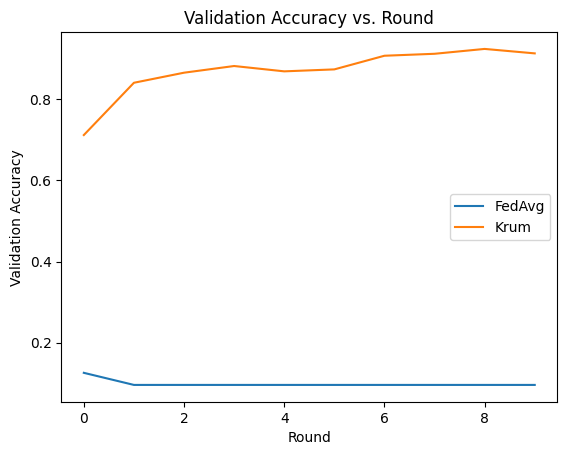

In [ ]:
plt.title('Validation Accuracy vs. Round')
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.plot(val_acc_fed, label='FedAvg')
plt.plot(val_acc_krum, label='Krum')
plt.legend()
plt.show()

In [ ]:
# Final global test performance(FedAvg)
test_acc_fedavg, test_loss_fedavg = evaluate(global_model_fedavg, test_loader)
print(f"\n[Final Test Results] FedAvg: Accuracy = {test_acc_fedavg*100:.2f}% | Loss = {test_loss_fedavg:.4f}")


[Final Test Results] FedAvg: Accuracy = 9.80% | Loss = nan


In [ ]:
# Final global test performance(Krum)
test_acc_krum, test_loss_krum = evaluate(global_model_krum, test_loader)
print(f"\n[Final Test Results] Krum: Accuracy = {test_acc_krum*100:.2f}% | Loss = {test_loss_krum:.4f}")


[Final Test Results] Krum: Accuracy = 92.25% | Loss = 0.2419
